In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install xlrd
!pip install fuzzywuzzy python-Levenshtein
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import fuzz
# Load the Excel file

shark_attacks = pd.read_excel('/content/gdrive/MyDrive/GSAF5.xlsx')
shark_attacks.head()

Mounted at /content/gdrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.6 MB/s eta 0:00:00


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-01-23 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Shipwreck Cove,Bathing,Boy,M,12,...,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Cheynes beach,Surfing,Dale Kittow,M,37,...,Bronze whaler,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-11 00:00:00,2025.0,Provoked,USA,Hawaii,Off Haleiwa Boat Harbour Oahu,Diving,Male not stated was a dive tour worker,M,23,...,Not stated,Kevin McMurray Trackingsharks.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-02 00:00:00,2025.0,Unprovoked,New Caledonia,Grande Terre,Islet of Kendek near Koumac,Spearfishing,Robert Cuewapuru,M,40,...,Reportedly Tiger or Bull shark,Johannes Marchand Todd Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-02 00:00:00,2025.0,Unprovoked,Australia,South Australia,Granites Beach near Westall Streaky Bay,Surfing,Lance Appleby,M,28,...,Great White Shart estimated 4.8m 16 ft,Glen Folkard: Simon De Marchi News.com.au: The...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# New Section

In [ ]:
shark_attacks.columns = shark_attacks.columns.str.strip()
shark_attacks = shark_attacks.drop(columns=['pdf',
 'href formula',
 'href',
 'Case Number',
 'Case Number.1',
 'original order',
 'Unnamed: 21',
 'Unnamed: 22'])
shark_attacks.columns.tolist() #dropping not relevant columns

['Date',
 'Year',
 'Type',
 'Country',
 'State',
 'Location',
 'Activity',
 'Name',
 'Sex',
 'Age',
 'Injury',
 'Fatal Y/N',
 'Time',
 'Species',
 'Source']

In [ ]:
#clean country column

shark_attacks['Country'] = shark_attacks['Country'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.upper()
shark_attacks['Country'] = shark_attacks['Country'].str.strip().fillna('Unknown') # replacing nan with 'Unknown'

# Create a dictionary to store similar country pairs
similar_countries_dict = {}

# Get unique countries to reduce redundant comparisons/ code was too slow without
unique_countries = shark_attacks['Country'].drop_duplicates()

# Find similar country names and add them to the dictionary
for i, country1 in enumerate(unique_countries):
    for j, country2 in enumerate(unique_countries):
        if i < j:  # Avoid comparing the same entry with itself
            similarity = fuzz.ratio(country1, country2)
            if similarity > 80 and similarity < 100:  # Exclude exact matches
                if country1 not in similar_countries_dict:
                    similar_countries_dict[country1] = [country2]
                else:
                    similar_countries_dict[country1].append(country2)

replacements = {
    'TURKS AND CAICOS': 'TURKS  CAICOS',
    'BRITISH OVERSEAS TERRITORY': 'ST HELENA BRITISH OVERSEAS TERRITORY',
    'ST MARTIN': 'ST MAARTIN',
    'UNITED ARAB EMIRATES': 'UNITED ARAB EMIRATES UAE',
    'ANDAMAN  NICOBAR ISLANDAS': 'ANDAMAN ISLANDS',
    'NORTH ATLANTIC OCEAN': 'ATLANTIC OCEAN',
    'MID ATLANTIC OCEAN': 'ATLANTIC OCEAN',
    'SOUTH ATLANTIC OCEAN': 'ATLANTIC OCEAN',
    'SOUTH PACIFIC OCEAN': 'PACIFIC OCEAN',
    'NORTH PACIFIC OCEAN': 'PACIFIC OCEAN',
    'MIDPACIFC OCEAN': 'PACIFIC OCEAN',
    'SOUTHWEST PACIFIC OCEAN': 'PACIFIC OCEAN',
    'TRINIDAD  TOBAGO': 'TRINIDAD',
    'UAE': '',
    'ST HELENA': ''}

shark_attacks.Country = shark_attacks.Country.replace(replacements, regex=True).str.strip()
shark_attacks.Country.sort_values().unique()

array(['ADMIRALTY ISLANDS', 'AFRICA', 'ALGERIA', 'AMERICAN SAMOA',
       'ANDAMAN ISLANDS', 'ANGOLA', 'ANTIGUA', 'ARGENTINA', 'ARUBA',
       'ASIA', 'ATLANTIC OCEAN', 'AUSTRALIA', 'AZORES', 'BAHAMAS',
       'BAHREIN', 'BANGLADESH', 'BARBADOS', 'BAY OF BENGAL', 'BELIZE',
       'BERMUDA', 'BETWEEN PORTUGAL  INDIA', 'BRAZIL', 'BRITISH ISLES',
       'BRITISH NEW GUINEA', 'BRITISH OVERSEAS TERRITORY',
       'BRITISH VIRGIN ISLANDS', 'BRITISH WEST INDIES', 'BURMA', 'CANADA',
       'CAPE VERDE', 'CARIBBEAN SEA', 'CAYMAN ISLANDS', 'CENTRAL PACIFIC',
       'CEYLON', 'CEYLON SRI LANKA', 'CHILE', 'CHINA', 'COAST OF AFRICA',
       'COLOMBIA', 'COLUMBIA', 'COMOROS', 'COOK ISLANDS', 'CORAL SEA',
       'COSTA RICA', 'CRETE', 'CROATIA', 'CUBA', 'CURACAO', 'CYPRUS',
       'DIEGO GARCIA', 'DJIBOUTI', 'DOMINICAN REPUBLIC', 'ECUADOR',
       'EGYPT', 'EGYPT  ISRAEL', 'EL SALVADOR', 'ENGLAND',
       'EQUATORIAL GUINEA  CAMEROON', 'FALKLAND ISLANDS',
       'FEDERATED STATES OF MICRONESIA', 'FIJ

In [ ]:
# clean State column

shark_attacks.State = shark_attacks.State.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.upper()
shark_attacks.State = shark_attacks.State.str.replace(r'\s+', ' ', regex=True)
shark_attacks.State = shark_attacks.State.str.strip()
shark_attacks.State = shark_attacks.State.replace('nan', 'unknown').str.upper().fillna('Unknown')

shark_attacks.State.sort_values().unique()

# Create a dictionary to store similar state pairs
similar_states_dict = {}

# Get unique states to reduce redundant comparisons/ code was too slow without
unique_states = shark_attacks.State.drop_duplicates()

# Find similar country names and add them to the dictionary
for i, state1 in enumerate(unique_states):
    for j, state2 in enumerate(unique_states):
        if i < j:  # Avoid comparing the same entry with itself
            similarity = fuzz.ratio(state1, state2)
            if similarity > 80 and similarity < 100:  # Exclude exact matches
                if country1 not in similar_states_dict:
                    similar_states_dict[state1] = [state2]
                else:
                    similar_states_dict[state1].append(state2)



reversed__similar_states_dict = {v[0]: k for k, v in similar_states_dict.items()} # complexity

replacements = {'WESTERM AUSTRALIA': 'WESTERN AUSTRALIA',
 'GRAND TERRE': 'GRANDE TERRE',
 'FLORIA': 'FLORIDA',
 'NEW PROVIDENCE ISOAD': 'NEW PROVIDENCE ISLAND',
 'NORTH SOUTH CAROLINA': 'NORTH CAROLINA',
 'NEW SOUTH ALES': 'NEW SOUTH WALES',
 'OUT ISLANDS': 'SOUTH ISLAND',
 'GUERRRERO': 'GUERRERO',
 'NORTHLANDS': 'NORTH ISLAND',
 'QUINTA ROO': 'QUINTANA ROO',
 'SAN ANDRS ISLAND': 'SAN ANDRES ISLAND',
 'LUCAYAN LUCAYAN ARCHIPELAGO': 'LUCAYAN ARCHIPELAGO',
 'AMBERGRIS KEY': 'AMBERGRIS CAYE',
 'GUANACOSTE': 'GUANACASTE',
 'US VIRGIN ISLANDS': 'VIRGIN ISLANDS',
 'VANUA LEVU':  'OFF VANUA LEVU',
 'SAINT GILLES': 'SAINTGILLES',
 'COOK ISLANS': 'COOK ISLANDS',
 'ALAGOAS': 'LAGOS',
 'BAJA CALIFORNIA SUR': 'BAJA CALIFORNIA',
 'SAINT LEU': 'SAINTLEU',
 'TUAMOTUS': 'TUAMOTOS',
 'NORTHERN ORO PROVINCE':  'NORTHERN PROVINCE',
 'INHAMBANE PROVINCE':  'INHAMBE PROVINCE',
 'LETANGSAL': 'LETANGSALE',
 'SAINTBENOT': 'SAINTBENOIT',
 'TOAMASINA PROVINCE': 'ADANA PROVINCE',
 'ANCONA PROVINCE': 'COLN PROVINCE',
 'VITI LEVU': 'VITA LEVU',
 'SINAI PENINSULA': 'SOUTH SINAI PENINSULA',
 'MAKIRAULUWA PROVINCE': 'MAKORAULAWA PROVINCE',
 'SPLITDALMATIA COUNT': 'SPLITDALMATIA COUNTY',
 'BONIN ISLANDS': 'BIMINI ISLANDS',
 'MALAITA PROVINCE': 'MALAMPA PROVINCE',
 'SOUTH CHUNGCHEONG PROVINCE': 'SOUTH CHUNGCHONG PROVINCE',
 'TAVENUI': 'TAVEUNI',
 'PACIFIC COAST': 'NORTH PACIFIC COAST',
 'CAPVERT PENINSULA': 'CAP VERT PENINSULA',
 '5AINTDENIS': 'SAINTDENIS',
 'EHIME PREFECTURE': 'AICHI PREFECTURE',
 'WAKE ISLAND': 'WAKAYA ISLAND',
 'TYRRENIAN SEA': 'TYRRHENIAN SEA',
 'IN THE ENGLISH CHANNEL': 'ENGLISH CHANNEL',
 'EASTERN CAROLINE ISLANDS': 'WESTERN CAROLINE ISLANDS',
 'VERA CRUZ': 'VERACRUZ',
 'LIGUARIA': 'LIGURIA',
 'BAY OF MAPUTU': 'BAY OF MAPUTO',
 'BOUGAINVILLE NORTH SOLOMONS': 'NEAR BOUGAINVILLE NORTH SOLOMONS',
 'OFF THE COAST OF WEST AFRICA': 'OFF COAST OF WEST AFRICA',
 'SOFALA PROVINCE': 'SHEFA PROVINCE',
 'LOMAIVITI PROVINE': 'LOMAIVITI PROVINCE',
 'QUEZON': 'QUEAON',
 'PACIFIC OCEAN': 'SOUTH PACIFIC OCEAN',
 '1000 MILES WEST OF HAWAII': '1000 MILES EAST OF HAWAII',
 'ABAU SUB DISTRICT CENTRAL PROVINCE': 'ABAU SUBDISTRICTCENTRAL PROVINCE',
 'SOUTH KOREA': 'SOUTH SHORE',
 'SHATALARAB RIVER': 'SHATTALARAB RIVER',
 'CALVADOS ARCHIPELAGO': 'CYCLADES ARCHIPELAGO',
 'GALICA':  'GALICIA',
 'OFF CAPE HAITIEN': 'CAPE HAITIEN',
 'MLAGA': 'MALAGA',
 'OFF THE COAST OF SOUTH AMERICA': 'OFF THE COAST OF WEST AFRICA'}


shark_attacks.State = shark_attacks.State.replace(replacements, regex=True).str.strip()
shark_attacks.State.unique()

array(['WESTERN AUSTRALIA', 'HAWAII', 'GRANDE TERRE', 'SOUTH AUSTRALIA',
       'NORTH OF MARSA ALAM', 'QUEENSLAND', 'PHANG NGA PROVINCE',
       'BAY OF WAITANGI', 'KAAFU', 'MAUI', 'FLORIDA', 'TELA',
       'TRUJILLO COLON', 'SOUTHERN MOROCCO', 'MONTEGO BAY',
       'GULF OF HONDURAS', 'NSW', 'TEXAS', 'CALIFORNIA',
       'MAAHVAH LAAMU ATOLL', 'GALVESTON', 'PROVIDENCIALES ISLAND',
       'GAMBIER ISLANDS', 'SOUTH CAROLINA', 'GRAET COURLAND BAY',
       'CLARENCE TOWN LONG ISAND', 'NUNU ATOLL', 'MAHARASHTRA', 'Unknown',
       'NEW SOUTH WALES', 'PARADISE ISLAND', 'EASTERN CAPE PROVINCE',
       'SONORA', 'SOUTH ISLAND', 'GUERRERO', 'NEW PROVIDENCE ISLAND',
       'JALISCO', 'GRAND BAHAMA ISLAND', 'NORTH ISLAND',
       'SOUTHERN RED SEA', 'QUINTANA ROO', 'BELIZE DISTRICT',
       'SOUTH SINAI', 'BOLINAO', 'NORTH CAROLINA', 'VALENCIA', 'NORTE',
       'SAVAII ISLAND', 'NEW YORK', 'SAN ANDRES ISLAND',
       'GALAPAGOS ISLANDS', 'RED SEA PROTECTORATE', 'FREEPORT', 'TAHITI',
       'POU

In [ ]:
# clean activity columns

shark_attacks.Activity_Original = shark_attacks.Activity

shark_attacks.Activity_Cleaned = (shark_attacks.Activity_Original.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower().str.strip().fillna('Unknown'))

shark_attacks.Activity_Cleaned = shark_attacks.Activity_Cleaned.replace('', 'Unknown')

replacements = {
    'Crew swimming alongside their anchored ship': 'swimming around anchored ship',
    'swmming': 'swimming',
    'oveboard': 'overboard',
    'boat of a hawaiian brig was stove in by  whale': 'boat sinking',
    'surfng': 'surfing',
    'fihing': 'fishing',
    'snorkelling': 'snorkeling',
 'foilboarding': 'foil boarding',
 'paddleboarding': 'paddle boarding',
 'boggie boarding': 'boogie boarding',
 'surfskiing': 'surf skiing',
 'harassing a shark': 'harassing sharks',
 'standup paddleboarding': 'stand up paddleboarding',
 'bodyboarding': 'body boarding',
 'standup paddle boarding': 'standup paddleboarding',
 'kiteboarding': 'kite boarding',
 'airsea diasaster': 'airsea disaster',
 'removing shark from a net': 'removing shark from net',
 'killing a shark': 'killing sharks',
 'paddleskiing': 'paddle skiing',
 'standing on sandbar': 'standing on sandbank',
    'standup paddle boarding':'standup paddle boarding',
 'stand up paddle boarding': 'standup paddle boarding',
 'standup paddleboarding': 'standup paddle boarding',
 'airsea diasaster':  'airsea disaster',
 'killing  sharks': 'killing sharks',
    'stand up paddle boarding': 'standup paddle boarding'}

shark_attacks.Activity_Cleaned = shark_attacks.Activity_Cleaned.replace(replacements, regex=True)

activity_mapping = {
    'wreck': 'wreck',
    'washing': 'washing item/animal',
    'diving': 'diving',
    'swimming': 'swimming',
    'bathing': 'bathing',
    'surfing': 'surfing',
    'paddling': 'paddling',
    'rescuing': 'rescuing',
    'floating': 'floating',
    'plane|aircraft': 'aircraft',
    'sank|sinking|capsized': 'boat sinking',
    'shark.*fishing|fishing.*shark': 'fishing shark',
    'fishing for': 'fishing fish other than shark',
    'fishing': 'fishing',
    'fell': 'fell',
    'jumped': 'jumped',
    'adrift': 'adrift',
    'wearing life jackets': 'adrift',
    'sunk': 'sunk',
    'abandoning': 'abandoning',
    'airsea diasaster': 'air disaster'}

# Apply regex-based categorization
for pattern, replacement in activity_mapping.items():
    shark_attacks.loc[
        shark_attacks.Activity_Cleaned.str.contains(pattern, case=False, na=False), 'Activity_Cleaned'
    ] = replacement

# Create a dictionary to store similar state pairs
similar_Activity_Cleaned_dict = {}

# Get unique states to reduce redundant comparisons/ code was too slow without
unique_Activity_Cleaned = shark_attacks.Activity_Cleaned.drop_duplicates()

# Find similar country names and add them to the dictionary
for i, act1 in enumerate(unique_Activity_Cleaned):
    for j, act2 in enumerate(unique_Activity_Cleaned):
        if i < j:  # Avoid comparing the same entry with itself
            similarity = fuzz.ratio(act1, act2)
            if similarity > 90 and similarity < 100:  # Exclude exact matches
                if act1 not in similar_Activity_Cleaned_dict:
                    similar_Activity_Cleaned_dict[act1] = [act2]
                else:
                    similar_Activity_Cleaned_dict[act1].append(act2)

similar_Activity_Cleaned_dict
reversed_similar_Activity_dict = {v[0]: k for k, v in similar_Activity_Cleaned_dict.items()}
reversed_similar_Activity_dict
shark_attacks.Activity_Cleaned.unique()

<ipython-input-7-5904a3e0b07b>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  shark_attacks.Activity_Original = shark_attacks.Activity
<ipython-input-7-5904a3e0b07b>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  shark_attacks.Activity_Cleaned = (shark_attacks.Activity_Original.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower().str.strip().fillna('Unknown'))


array(['bathing', 'surfing', 'diving', ...,
       'crew swimming alongside their anchored ship',
       '4 men were bathing', 'wreck of  large double sailing canoe'],
      dtype=object)

In [ ]:
# Clean and convert age to numeric value, keeping specific categories

def clean_age(age):

    # Handle case where age is already a numeric value
    if isinstance(age, (int, float)):
        return age

    # Handle case where age is a string
    if isinstance(age, str):
        age = age.lower().strip()

        # Handle specific categories
        if age in ['middle age', 'young', 'teen', 'minor', 'adult', 'elderly','toddler', 'child', 'kid']:
            return age
        elif age in ['x', 'make line green', 'f', 'm', 'a.m.']:
            return np.nan
        elif 'months' in age or 'month' in age:  # Handle age in months
            return 'baby'
        elif age.startswith('mid-') and re.match(r'\d+', age.split('-')[1]):
            return int(age.split('-')[1][0])  # Extracts the base number of the 'mid-20s' case (returns 20)
        elif age.startswith('ca.') and re.match(r'\d+', age[3:].strip()):  # Adjusted to correctly handle 'ca. 33'
            return int(re.findall(r'\d+', age[3:].strip())[0])  # Extracts 'ca. 33' to 33
        elif re.match(r'^\d+$', age):  # Handle simple numeric ages
            return int(age)
        elif re.match(r'^\d+\s?[+-]?$', age):  # Handle ages like '60+' or '40-'
            return int(re.findall(r'\d+', age)[0])
        elif re.match(r'\d+', age):  # Handle ranges or mixed ages like '30s', '20/30'
            return int(re.findall(r'\d+', age)[0])
        elif re.search(r'both\s\d+', age):  # Handle "both 11", "both 9", etc.
            return int(re.findall(r'\d+', age)[0])
        elif 'to' in age:  # Handle ranges like '20 to 30'
            numbers = re.findall(r'\d+', age)
            return np.mean([int(num) for num in numbers])
        elif 'and' in age:  # Handle age lists like '28 & 22'
            numbers = re.findall(r'\d+', age)
            return np.mean([int(num) for num in numbers])
        elif re.match(r'[a-z]+', age):  # Handle known string categories
            return age
        else:
            return np.nan  # Return NaN for unknown or invalid values

    # Handle cases where age is not valid
    return np.nan

# Assuming shark_attacks is your DataFrame, apply the clean_age function to the Age column
shark_attacks['Age'] = shark_attacks['Age'].apply(clean_age)



#Create a new column 'AgeGroup'. This column should categorize customers as:
#'baby' (age<=2), 'child' (age <= 12), 'teen' (12 < age <=18), 'young' (19 <= age <= 39) 'middle age' (40 < age <= 59), and 'senior' (age > 60)

def categorize_age(age):

    if isinstance(age, (int, float)):  # Numeric ages
        if age <= 2:
            return 'baby'
        elif age <= 12:
            return 'child'
        elif 12 < age <= 18:
            return 'teen'
        elif 19 <= age <= 39:
            return 'young'
        elif 40 <= age <= 59:
            return 'middle age'
        elif age >= 60:
            return 'senior'
        else:
            return None

    elif isinstance(age, str):  # Handling categorical string values
        age = age.lower().strip()
        if age in ['baby']:
            return 'baby'
        elif age in ['child', 'kid', 'a minor']:
            return 'child'
        elif age in ['teen', 'teens']:
            return 'teen'
        elif age in ['young']:
            return 'young'
        elif age in ['middle age']:
            return 'middle age'
        elif age in ['elderly', 'senior']:
            return 'senior'
        else:
            return None  # For unknown cases

    return None  # Handle NaN or other invalid values

# Apply the function to create 'AgeGroup' column
shark_attacks['AgeGroup'] = shark_attacks['Age'].apply(categorize_age)

# Check the values in 'AgeGroup'
print(shark_attacks['AgeGroup'].value_counts())
print("Null values:",shark_attacks['AgeGroup'].isna().sum())

#check with group the strategy to fill empty rows

AgeGroup
young         1899
teen           883
middle age     686
child          344
senior         157
baby             7
Name: count, dtype: int64
Null values: 3016


In [ ]:
shark_attacks.Age.unique()

array([12, 37, 23, 40, 69, 60, nan, 57, 24, 45, 61, 27, 38, 16, 33, 30,
       15, 41, 14, 26, 'middle age', 21, 49, 25, 46, 19, 20, 65, 64, 13,
       11, 32, 29, 10, 62, 39, 22, 66, 52, 44, 47, 55, 59, 8, 50, 34, 9,
       35, 77, 42, 73, 18, 67, 6, 53, 68, 43, 51, 17, 31, 58, 28, 'teen',
       56, 36, 7, 48, 54, 75, 70, 4, 63, 74, 'a minor', 3, 82, 72, 71,
       'baby', 86, 'teens', 84, 5, 87, 'elderly', 2, 'adult', 1, 81, 78,
       'young'], dtype=object)

In [ ]:
# check different most common words for Injury column

from collections import Counter
import pandas as pd

# Remove NaN values and join all text in the column
all_text = " ".join(shark_attacks['Injury'].dropna()).lower()

# Split text into words
word_list = all_text.split()

# Count word occurrences
word_counts = Counter(word_list)

# Display the 100 most common words
print(word_counts.most_common(100))

[('to', 1959), ('bitten', 1550), ('shark', 1255), ('&', 1019), ('leg', 983), ('no', 982), ('fatal', 971), ('left', 961), ('right', 954), ('foot', 853), ('lacerations', 685), ('injury', 639), ('provoked', 617), ('incident', 610), ('by', 604), ('hand', 474), ('injury,', 460), ('lacerated', 440), ('fatal,', 430), ('arm', 429), ('thigh', 423), ('the', 419), ('of', 415), ('on', 376), ('and', 337), ('minor', 329), ('calf', 291), ('laceration', 278), ('severed', 264), ('lower', 259), ('ankle', 243), ('in', 232), ('bit', 231), ('a', 229), ('his', 225), ('puncture', 201), ('wounds', 196), ('boat', 181), ('was', 178), ('but', 177), ('forearm', 172), ('injuries', 163), ('board', 161), ('hooked', 160), ('injured', 154), ('knee', 151), ('from', 151), ('recovered', 144), ('survived', 144), ('bitten,', 136), ('sharks', 135), ('he', 132), ('not', 129), ('severely', 127), ('were', 123), ('body', 122), ('legs', 105), ('occupants,', 102), ('surfboard', 98), ('severe', 96), ('2', 93), ('amputated', 92), (

In [ ]:
# Define function to categorize injuries:

# Find rows where 'Injury' contains 'no injury' or 'no injuries'
no_injury_cases = shark_attacks[shark_attacks['Injury'].str.contains(r'no\s*i[nj]{1,2}uri?e?s?', case=False, na=False, regex=True)]

# minor injuries: superficial wounds, minor lacerations;
# moderate injuries: deep lacerations, puncture wounds, tissue loss;
# severe injuries: life-threating wounds, amputations, major tissue loss;
# fatal injuries: drowning, death, organ damage

def categorize_injury(injury):
    if pd.isna(injury):  # Handle missing values
        return np.nan

    injury = injury.lower()  # Convert to lowercase for consistent matching

    # Check for 'no injury' cases first
    if any(word in injury for word in ['no injury', 'no injuries', 'no inujuri', 'no ijnury','no inury','no attack']):
        return 'no injury'

    # Define injury groups based on keywords
    if  any(word in injury for word in ['fatal','disappeared','death','drowned','drowning','killed']):
        return 'fatal injuries'
    elif any(word in injury for word in ['severe','severed','severely', 'severly','severted','serious','significant','amputated','lost','cut','cuts','tissue loss','life threatening','not recovered', 'inch','cm']):
        return 'severe injuries'
    elif any(word in injury for word in ['lacerations','laceration','lacerated','moderate', 'puncture','punctures', 'non-life','bite','bitten', 'leg injured','leg injury', 'hand']):
        return 'moderate injuries'
    elif any(word in injury for word in ['minor','small','abrasion','abrasions','bruised','bruises','superficial','shallow']):
        return 'minor injuries'
    else:
        return 'other/unknown'  # Default category if no match is found

# Apply function to create the 'InjuryGroup' column
shark_attacks['InjuryGroup'] = shark_attacks['Injury'].apply(categorize_injury).fillna('other/unknown')

# Check the values in the InjuryGroup
print(shark_attacks['InjuryGroup'].value_counts())
print("Null values:",shark_attacks['InjuryGroup'].isna().sum())

InjuryGroup
moderate injuries    2849
fatal injuries       1619
no injury             888
other/unknown         787
severe injuries       594
minor injuries        255
Name: count, dtype: int64
Null values: 0


In [ ]:
# standardize Fatal column to N and Y
shark_attacks['FatalGroup Y/N'] = shark_attacks['Fatal Y/N'].replace({'F': np.nan,'M': np.nan, np.nan: np.nan,'UNKNOWN': np.nan, 2017: np.nan, 'Y': 'Y','Y x 2': 'Y','y': 'Y'})
shark_attacks['FatalGroup Y/N'] = shark_attacks['FatalGroup Y/N'].replace(to_replace=r'^\s*N\s*$', value='N', regex=True)
shark_attacks['FatalGroup Y/N'] = shark_attacks['FatalGroup Y/N'].fillna('N').replace({'n': 'N','Nq': 'N',' N': 'N'})

# Check the unique values in 'FatalGroup'
print(shark_attacks['FatalGroup Y/N'].value_counts())
print("Null values:",shark_attacks['FatalGroup Y/N'].isna().sum())

FatalGroup Y/N
N    5522
Y    1470
Name: count, dtype: int64
Null values: 0


In [ ]:
# Iryna added
print(shark_attacks[['Sex', 'Date', 'Location']].head())
# Replaced empty strings and whitespace-only strings with NaN
shark_attacks['Sex'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
shark_attacks['Date'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
shark_attacks['Location'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
# Sex Column
# Striped whitespace and convert to uppercase
shark_attacks['Sex'] = shark_attacks['Sex'].str.strip().str.upper()
# Retained only valid entries ('M' or 'F'), set others to NaN
shark_attacks['Sex'] = shark_attacks['Sex'].apply(lambda x: x if x in ['M', 'F'] else np.nan)
# Date Column
# Converted to datetime, coerce errors to NaT
shark_attacks['Date'] = pd.to_datetime(shark_attacks['Date'], errors='coerce')
#Location Column
# Striped leading/trailing whitespace and standardize case
shark_attacks['Location'] = shark_attacks['Location'].str.strip().str.title()
# Removed entries with excessive length or non-alphabetic characters
shark_attacks['Location'] = shark_attacks['Location'].apply(lambda x: x if pd.notnull(x) and len(x) < 100 and x.isalpha() else np.nan)
# Droped duplicate rows based on 'Sex', 'Date', and 'Location'
shark_attacks.drop_duplicates(subset=['Sex', 'Date', 'Location'], inplace=True)
# Displayed cleaned data overview
print("\nCleaned Data Overview:")
print(shark_attacks[['Sex', 'Date', 'Location']].head())


  Sex                 Date                                 Location
0   M  2025-01-23 00:00:00                           Shipwreck Cove
1   M  2025-01-22 00:00:00                           Cheynes beach 
2   M  2025-01-11 00:00:00            Off Haleiwa Boat Harbour Oahu
3   M  2025-01-02 00:00:00              Islet of Kendek near Koumac
4   M  2025-01-02 00:00:00  Granites Beach near Westall Streaky Bay


<ipython-input-12-60895ed09900>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shark_attacks['Sex'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
<ipython-input-12-60895ed09900>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 


Cleaned Data Overview:
  Sex       Date Location
0   M 2025-01-23      NaN
1   M 2025-01-22      NaN
2   M 2025-01-11      NaN
3   M 2025-01-02      NaN
5   M 2024-12-29      NaN


In [ ]:
#Remove the coma and the zero in the Year column

shark_attacks['Year'] = shark_attacks['Year'].fillna(0).astype(int).astype(str)

print(shark_attacks)

           Date  Year        Type        Country                  State  \
0    2025-01-23  2025  Unprovoked      AUSTRALIA      WESTERN AUSTRALIA   
1    2025-01-22  2025  Unprovoked      AUSTRALIA      WESTERN AUSTRALIA   
2    2025-01-11  2025    Provoked            USA                 HAWAII   
3    2025-01-02  2025  Unprovoked  NEW CALEDONIA           GRANDE TERRE   
5    2024-12-29  2024  Unprovoked          EGYPT    NORTH OF MARSA ALAM   
...         ...   ...         ...            ...                    ...   
6938        NaT     0  Unprovoked     MADAGASCAR         ADANA PROVINCE   
6944        NaT     0    Provoked           CUBA        HAVANA PROVINCE   
6948        NaT     0  Unprovoked       KIRIBATI        GILBERT ISLANDS   
6968        NaT     0  Unprovoked        REUNION             SAINTDENIS   
6969        NaT     0  Unprovoked   SOUTH AFRICA  WESTERN CAPE PROVINCE   

       Location                          Activity  \
0           NaN                           Bath

In [ ]:
#Listing the unique values in Type column

shark_attacks['Type'].unique()

array(['Unprovoked', 'Provoked', ' Provoked', 'Questionable',
       'Watercraft', 'Sea Disaster', nan, '?', 'Unconfirmed',
       'Unverified', 'Invalid', 'Boat'], dtype=object)

In [ ]:
unique_counts = shark_attacks.groupby('Type').nunique()

print(unique_counts)

              Date  Year  Country  State  Location  Activity  Name  Sex  Age  \
Type                                                                           
 Provoked        2     2        2      2         0         1     2    1    0   
?                1     1        1      1         0         1     1    1    1   
Boat             4     3        4      4         2         2     4    0    0   
Invalid        430   139       63    106        77       147   353    2   61   
Provoked       516   126       57    151        81       203   464    2   62   
Questionable    19     6        8     15         2        11    17    2   12   
Sea Disaster   182    95       51     99        17       163   126    2   26   
Unconfirmed      1     1        1      1         0         1     0    0    0   
Unprovoked    3886   224      143    522       430       825  3592    2   87   
Unverified       1     1        1      1         0         1     1    1    0   
Watercraft     279   104       27     52

In [ ]:
#Rename several types into one type

shark_attacks['Type'] = shark_attacks['Type'].replace(['Unconfirmed', 'Under investigation', 'Unverified', 'Invalid','?'], 'Unknown')
shark_attacks['Type'] = shark_attacks['Type'].replace(['Sea Disaster', 'Watercraft', 'Boat'], 'Unknown')
shark_attacks['Type'].unique()

array(['Unprovoked', 'Provoked', ' Provoked', 'Questionable', 'Unknown',
       nan], dtype=object)

In [ ]:
#Remove blank space of ' Unprovoked'

shark_attacks['Type'] = shark_attacks['Type'].str.lstrip()
shark_attacks['Type'].unique()

array(['Unprovoked', 'Provoked', 'Questionable', 'Unknown', nan],
      dtype=object)

In [ ]:
#Cleaning species :

#STEP 1 : Remove blank space :
shark_attacks.columns = shark_attacks.columns.str.strip()

#STEP 2 : How many unique values ?
shark_attacks['Species'].nunique() #1706 unique values

#STEP 3 : Standardize all variations of "tiger shark" into a single value "Tiger shark" using replace() with Regex (Flexible for Multiple Variations)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*tiger shark.*', 'Tiger shark', regex=True)

#do the same for the other species
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*white shark.*', 'White shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*bull shark.*', 'Bull shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*whitetip shark.*', 'Whitetip shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*whaler shark.*', 'Whaler shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*small shark.*', 'Small shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*large shark.*', 'Large shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*Zambesi shark.*', 'Zambesi shark', regex=True)
shark_attacks['Species'] = shark_attacks['Species'].replace(r'(?i).*great white.*', 'White shark', regex=True)

#STEP 4 : Check the unique values
shark_attacks['Species'].nunique()




NameError: name 'shark_attacks' is not defined

In [ ]:
shark_attacks.columns.tolist()

['Date',
 'Year',
 'Type',
 'Country',
 'State',
 'Location',
 'Activity',
 'Name',
 'Sex',
 'Age',
 'Injury',
 'Fatal Y/N',
 'Time',
 'Species',
 'Source',
 'Activity_Cleaned',
 'AgeGroup',
 'InjuryGroup',
 'FatalGroup Y/N']

In [ ]:
# Hypothesis 1

# If there is correlation between the type of species with the number of fatal cases - exploring whether the type of the shark can predict the fatality of the incident.

pivot_table = shark_attacks.pivot_table(index='Species', columns='FatalGroup Y/N', aggfunc='size', fill_value=0)
pivot_table

# conclusions about species

FatalGroup Y/N,N,Y
Species,,
,5,0
,1,0
"""gummy"" shark (Rhizoprionodon or Loxodon) 1.2 m [4']",1,0
1.5 m [5'] dusky shark,1,0
6' to 8' shark,1,0
...,...,...
"unknown, possibly a white shark",1,0
whaler shark,1,0
white shark,1,0


<Axes: xlabel='Country'>

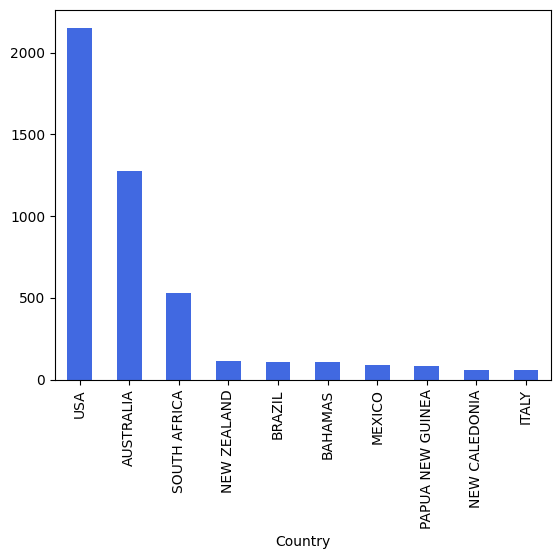

In [ ]:
# Hypothesis 2
# Higher number of shark attacks based on the location - in which locations we notice higher number of incidents.
# assuming each row one incident

shark_attacks.groupby('Country')['FatalGroup Y/N'].agg(['count']).sort_values(by='count',ascending=False).head(10).plot(kind='bar', legend=False, color='royalblue')

#pivot_table_location = shark_attacks.pivot_table(index=['Country'], columns='FatalGroup Y/N', aggfunc='size', fill_value=0)
#pivot_table_location

In [ ]:
shark_attacks.groupby('Country')['FatalGroup Y/N'].agg(['count']).sort_values(by='count',ascending=False).head(10)

,count
Country,
USA,2154
AUSTRALIA,1275
SOUTH AFRICA,527
NEW ZEALAND,116
BRAZIL,109
BAHAMAS,107
MEXICO,89
PAPUA NEW GUINEA,86
NEW CALEDONIA,60


<Axes: xlabel='Month'>

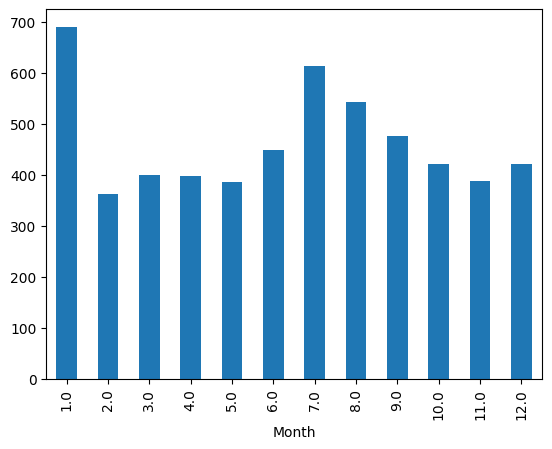

In [ ]:
# Hypothesis 3 - We expect higher number of shark attacks in summer months - to test this hypothesis whether is true

shark_attacks['Month'] = shark_attacks['Date'].dt.month

shark_attacks.groupby('Month')['FatalGroup Y/N'].agg(['count']).sort_values(by='Month').plot(kind='bar', legend=False)

# We notice as expected hifgher number of cases in summer months. But we also notice that Jnauary has sthe highest number.




In [ ]:
grouped_data = shark_attacks.groupby(['Country','Month'])['FatalGroup Y/N'].agg(['count']).sort_values(by='count')

filtered_data = grouped_data[grouped_data.index.get_level_values('Month') == 1].sort_values(by='count')
print(filtered_data)

#conclusion that Australia, ZA, USA, NZ affect the data

                        count
Country          Month       
MONTENEGRO       1.0        1
ANDAMAN ISLANDS  1.0        1
BERMUDA          1.0        1
GREECE           1.0        1
GREENLAND        1.0        1
...                       ...
PAPUA NEW GUINEA 1.0       15
NEW ZEALAND      1.0       35
USA              1.0       99
SOUTH AFRICA     1.0      115
AUSTRALIA        1.0      225

[80 rows x 1 columns]


<Axes: xlabel='Activity_Cleaned'>

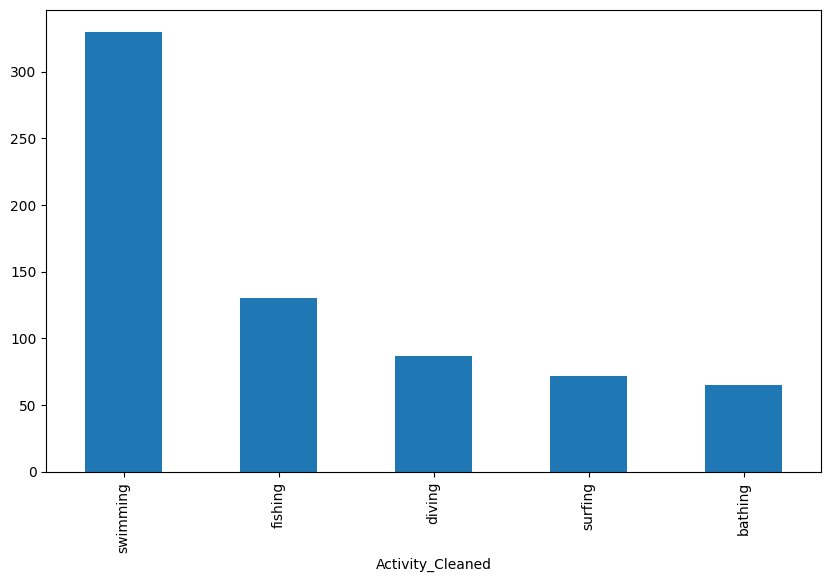

In [ ]:
# Hypothesis 4 - How the type of activity can predict the possibility for a fatal incident - the correlation between activity and number of fatal incidents

shark_attacks.head()

shark_attacks_filtered = shark_attacks[shark_attacks['FatalGroup Y/N'] == 'Y']

pivot_table1 = shark_attacks_filtered.pivot_table(index='Activity_Cleaned', columns='Type', values='FatalGroup Y/N', aggfunc='size', fill_value=0)
pivot_table1

top_5 = pivot_table1.sum(axis=1).nlargest(5)
top_5_df = pivot_table1.loc[top_5.index]

top_5.drop(columns='Total').plot(kind='bar', stacked=True, figsize=(10, 6))





In [ ]:
shark_attacks.Activity_Cleaned.isna()
shark_attacks.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,Activity_Cleaned,AgeGroup,InjuryGroup,FatalGroup Y/N,Month
0,2025-01-23,2025,Unprovoked,AUSTRALIA,WESTERN AUSTRALIA,NaN,Bathing,Boy,M,12,Minor bite to lower body,N,1711hrs,Not stated,Bob Myatt GSAF,bathing,child,moderate injuries,N,1.0
1,2025-01-22,2025,Unprovoked,AUSTRALIA,WESTERN AUSTRALIA,NaN,Surfing,Dale Kittow,M,37,None - chunk of surfboard bitten out,N,1600hrs,Bronze whaler,Bob Myatt GSAF,surfing,young,moderate injuries,N,1.0
2,2025-01-11,2025,Provoked,USA,HAWAII,NaN,Diving,Male not stated was a dive tour worker,M,23,Bitten on the arm,N,1340hrs,Not stated,Kevin McMurray Trackingsharks.com,diving,young,moderate injuries,N,1.0
3,2025-01-02,2025,Unprovoked,NEW CALEDONIA,GRANDE TERRE,NaN,Spearfishing,Robert Cuewapuru,M,40,Severe arm injury and delay in medical treatme...,Y,1615hr,Reportedly Tiger or Bull shark,Johannes Marchand Todd Smith,fishing,middle age,severe injuries,Y,1.0
5,2024-12-29,2024,Unprovoked,EGYPT,NORTH OF MARSA ALAM,NaN,SCUBA Diving,Peppino Fappani,M,69,Injuries to stomach preventing attack on friend,N,?,Reportedly a Tiger Shark,Todd Smith : Kevin McMurray Trackingsharks .co...,diving,senior,other/unknown,N,12.0
